## Classification of Guitar Chords using Machine Learning Techniques

### Esteban Schmitt

### CS559

### 12-19-2024

#### I pledge my honor that I have abided by the Stevens honor system.

## First we import our libraries

#### The commented out parts only need to be done once

In [754]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile

import os
import librosa
from scipy.io import wavfile
from scipy.fftpack import fft
import IPython.display as ipd

# Download latest version

# path = kagglehub.dataset_download("fabianavinci/guitar-chords-v3")
# print("Path to dataset files:", path)


## Create function to extract the Pitch Class Profile from a file

In [755]:
# take out the pitch class profiles 
def extract_pcp(file_path):
    y, sr = librosa.load(file_path, sr=16000)  # Load audio
    
    # Get the chroma feature EPCP
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

    # the mean of each feature is the pitch amp
    pcpw = np.mean(chroma, axis=1)

    return pcpw 

# Example usage
pcpw = extract_pcp("./Training/Am/Am_acousticguitar_Mari_1.wav")
print("Pitch Class Profile:", len(pcpw))  
print(pcpw)
CHORD_SET = ["Am","Bb","Bdim","C","Dm","Em","F","G"]

Pitch Class Profile: 12
[0.18965377 0.05180019 0.05514509 0.07569993 0.6283576  0.05313141
 0.04508087 0.05198466 0.10632498 0.7866183  0.11494973 0.13400537]


#### Visualize our Pitch Class Profile

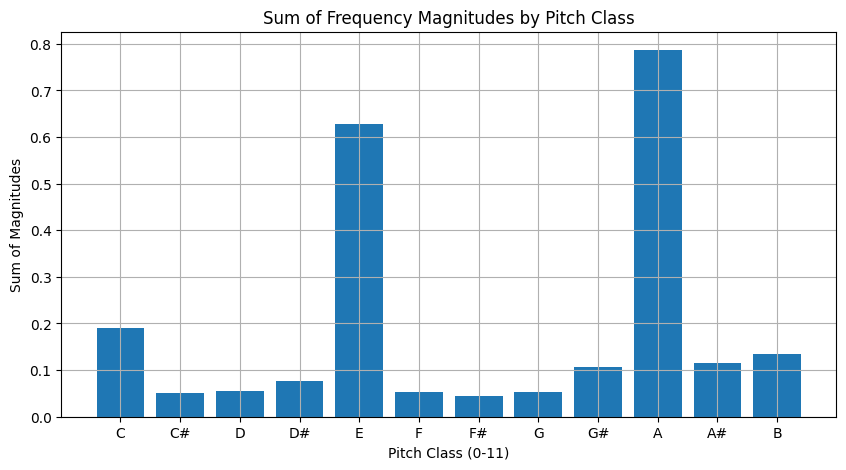

In [756]:
plt.figure(figsize=[10, 5])
plt.bar(np.arange(12), pcpw)
plt.xlabel('Pitch Class (0-11)')
plt.ylabel('Sum of Magnitudes')
plt.title('Sum of Frequency Magnitudes by Pitch Class')
plt.xticks(np.arange(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.grid()
plt.show()

## Create a dataset of pitch class profiles and store a csv of it

### ONLY NEED TO RUN ONCE (hence being commented now) 

### Once run you will have a csv on your pc and you will use it to load your data

In [757]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module='librosa')
# path_to_train = ["./Test","./Training"] # path to training
# data = []

# for path in path_to_train:
    
#     for chord in CHORD_SET:
#         print(f"Doing chord {chord}")
#         chord_folder = os.path.join(path,chord)

#         for file in os.listdir(chord_folder):
#             file_path = os.path.join(chord_folder,file)
    
#             _,pcp = extract_pcp(file_path)
#             data.append({"chord":chord,**{f"pcp_{i}": pcp[i] for i in range(12)}})


# frame = pd.DataFrame(data)
# frame.to_csv("FINALguitar_chord_dataset.csv")


## Split data into train and test

In [758]:
from sklearn.model_selection import train_test_split

pcp_data = pd.read_csv("FINALguitar_chord_dataset.csv")

X = pcp_data.drop(columns=["chord","Unnamed: 0"])
y = pcp_data['chord']

train_ratio = 0.70
test_ratio = 0.20
validation_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# shape of our data
print("Train Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Valid Features Shape:", X_val.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)
print("Valid Labels Shape:", y_valid.shape)

X_train.head()


Train Features Shape: (1231, 12)
Test Features Shape: (353, 12)
Valid Features Shape: (176, 12)
Train Labels Shape: (1231,)
Test Labels Shape: (353,)
Valid Labels Shape: (176,)


,pcp_0,pcp_1,pcp_2,pcp_3,pcp_4,pcp_5,pcp_6,pcp_7,pcp_8,pcp_9,pcp_10,pcp_11
1640,0.116161,0.106151,0.503821,0.120189,0.100426,0.138624,0.231377,0.507621,0.112606,0.125650,0.116705,0.903387
1372,0.205476,0.173633,0.174736,0.154783,0.436782,0.152678,0.184824,0.301372,0.246094,0.225082,0.256895,0.940566
956,0.894354,0.174151,0.228125,0.111889,0.572137,0.147774,0.176280,0.662538,0.170156,0.114855,0.116087,0.177303
809,0.130924,0.135456,0.122442,0.126282,0.150055,0.219542,0.156049,0.150704,0.112921,0.106385,0.105682,0.911871
726,0.160309,0.096388,0.203512,0.112298,0.133402,0.371599,0.204890,0.136637,0.358276,0.121620,0.164298,0.905536


In [759]:
y_test.head()

1089    Dm
1341    Em
1464     F
1123    Dm
1664     G
Name: chord, dtype: object

#### Check chord dispertion

In [760]:
print("Train set chord counts:")
print(y_train.value_counts())

print("\nTest set chord counts:")
print(y_test.value_counts())
print(y_valid.value_counts())


Train set chord counts:
chord
F       168
Dm      157
Em      153
Bb      153
Bdim    151
C       150
Am      150
G       149
Name: count, dtype: int64

Test set chord counts:
chord
C       52
Em      48
G       48
Am      47
Bb      45
Bdim    41
Dm      36
F       36
Name: count, dtype: int64
chord
Bdim    28
Dm      27
G       23
Am      23
Bb      22
Em      19
C       18
F       16
Name: count, dtype: int64


# Train and Test different models

## Start with Decision Tree

In [761]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=22)

# Train the model
clf.fit(X_train, y_train)
# Predict on the test set
y_pred_DecisionTree = clf.predict(X_test)
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_DecisionTree)
print(f"Decicion tree Accuracy: {accuracy}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_DecisionTree))



Decicion tree Accuracy: 0.9320113314447592

Classification Report:
              precision    recall  f1-score   support

          Am       0.96      0.91      0.93        47
          Bb       1.00      0.96      0.98        45
        Bdim       0.84      0.88      0.86        41
           C       0.93      0.96      0.94        52
          Dm       0.92      0.94      0.93        36
          Em       0.92      0.94      0.93        48
           F       0.94      0.92      0.93        36
           G       0.96      0.94      0.95        48

    accuracy                           0.93       353
   macro avg       0.93      0.93      0.93       353
weighted avg       0.93      0.93      0.93       353



### Testing KNN

In [762]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
report = classification_report(y_test,y_pred_knn)
print(report)

cm = confusion_matrix(y_test,y_pred_knn)

KNN Accuracy: 0.9773371104815864
              precision    recall  f1-score   support

          Am       0.92      0.96      0.94        47
          Bb       1.00      1.00      1.00        45
        Bdim       1.00      0.95      0.97        41
           C       1.00      0.98      0.99        52
          Dm       1.00      0.92      0.96        36
          Em       0.96      1.00      0.98        48
           F       0.97      1.00      0.99        36
           G       0.98      1.00      0.99        48

    accuracy                           0.98       353
   macro avg       0.98      0.98      0.98       353
weighted avg       0.98      0.98      0.98       353



### SVM 

In [763]:
from sklearn.svm import SVC

svclassifier_lin = SVC(kernel='linear')

# train and fit the SVM
svclassifier_lin.fit(X_train, y_train)


#predict the chords
y_pred_lin = svclassifier_lin.predict(X_test)

print("test size: ", len(y_test))
print("train size: ",len(y_train))
print("SVM Accuracy:",accuracy_score(y_test, y_pred_lin))

# Generate classification report
report = classification_report(y_test, y_pred_lin)

print("Classification Report:")
print(report)


test size:  353
train size:  1231
SVM Accuracy: 0.9688385269121813
Classification Report:
              precision    recall  f1-score   support

          Am       0.94      0.94      0.94        47
          Bb       1.00      0.98      0.99        45
        Bdim       1.00      0.90      0.95        41
           C       1.00      0.98      0.99        52
          Dm       0.92      0.97      0.95        36
          Em       0.91      1.00      0.95        48
           F       1.00      0.97      0.99        36
           G       1.00      1.00      1.00        48

    accuracy                           0.97       353
   macro avg       0.97      0.97      0.97       353
weighted avg       0.97      0.97      0.97       353



## LOGISTIC REGRESSION

In [764]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

report = classification_report(y_test,y_pred_logreg)
print("Log Reg Accuracy:",accuracy_score(y_test, y_pred_logreg))
print(report)

Log Reg Accuracy: 0.9603399433427762
              precision    recall  f1-score   support

          Am       0.94      0.94      0.94        47
          Bb       1.00      0.98      0.99        45
        Bdim       0.95      0.88      0.91        41
           C       1.00      0.96      0.98        52
          Dm       0.90      0.97      0.93        36
          Em       0.92      1.00      0.96        48
           F       0.97      0.97      0.97        36
           G       1.00      0.98      0.99        48

    accuracy                           0.96       353
   macro avg       0.96      0.96      0.96       353
weighted avg       0.96      0.96      0.96       353



## ADABOOST DECISION TREE

In [765]:
from sklearn.ensemble import AdaBoostClassifier

# Create the base estimator 
stump = DecisionTreeClassifier(max_depth=1)

# create an ada boost model with 500 in the orchestra
ada_boost = AdaBoostClassifier(estimator=stump,n_estimators=1000,learning_rate=2)


ada_boost.fit(X_train, y_train)

y_pred_ada = ada_boost.predict(X_test)
report = classification_report(y_test,y_pred_ada)
print("Adaboost Accuracy:",accuracy_score(y_test, y_pred_ada))

print(report)

Adaboost Accuracy: 0.9405099150141643
              precision    recall  f1-score   support

          Am       0.98      0.94      0.96        47
          Bb       0.98      0.98      0.98        45
        Bdim       0.77      0.83      0.80        41
           C       0.96      0.98      0.97        52
          Dm       0.97      0.94      0.96        36
          Em       0.93      0.88      0.90        48
           F       0.92      0.97      0.95        36
           G       1.00      1.00      1.00        48

    accuracy                           0.94       353
   macro avg       0.94      0.94      0.94       353
weighted avg       0.94      0.94      0.94       353



## NEURAL NETWORK

### Preprocess data

In [766]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Label encoding
label_encoder = LabelEncoder()
y_train_nn = label_encoder.fit_transform(y_train)  # Fit and transform on training data
y_test_nn = label_encoder.transform(y_test)   
y_val_nn = label_encoder.transform(y_valid) 
   
# Convert y_train and y_test into one-hot encoded format
y_train_nn = to_categorical(y_train_nn, num_classes=8)
y_test_nn = to_categorical(y_test_nn, num_classes=8)
y_val_nn = to_categorical(y_val_nn,num_classes=8)

scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)
X_val_nn = scaler.transform(X_val)


### Create a sequential Neural Network

#### 1 hidden layer

#### 15 neurons with L2 Reg at 0.01

#### ReLU activation 

In [767]:
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,LeakyReLU,ReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
num_classes = len(CHORD_SET)

model = Sequential()

model.add(Dense(15,input_dim = 12,kernel_regularizer=l2(0.01)))
model.add(ReLU())

model.add(Dense(num_classes,activation="softmax"))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fit our model to the data

Epoch 1/500
39/39 [==============================] - 0s 3ms/step - loss: 2.3044 - accuracy: 0.1438 - val_loss: 2.0944 - val_accuracy: 0.1756
Epoch 2/500
39/39 [==============================] - 0s 1ms/step - loss: 1.9883 - accuracy: 0.2348 - val_loss: 1.8197 - val_accuracy: 0.3343
Epoch 3/500
39/39 [==============================] - 0s 1ms/step - loss: 1.7259 - accuracy: 0.4874 - val_loss: 1.5811 - val_accuracy: 0.5779
Epoch 4/500
39/39 [==============================] - 0s 1ms/step - loss: 1.4904 - accuracy: 0.6881 - val_loss: 1.3666 - val_accuracy: 0.7450
Epoch 5/500
39/39 [==============================] - 0s 1ms/step - loss: 1.2814 - accuracy: 0.8188 - val_loss: 1.1843 - val_accuracy: 0.8272
Epoch 6/500
39/39 [==============================] - 0s 1ms/step - loss: 1.1031 - accuracy: 0.8692 - val_loss: 1.0229 - val_accuracy: 0.8754
Epoch 7/500
39/39 [==============================] - 0s 1ms/step - loss: 0.9498 - accuracy: 0.9001 - val_loss: 0.8883 - val_accuracy: 0.8867
Epoch 8/500
3

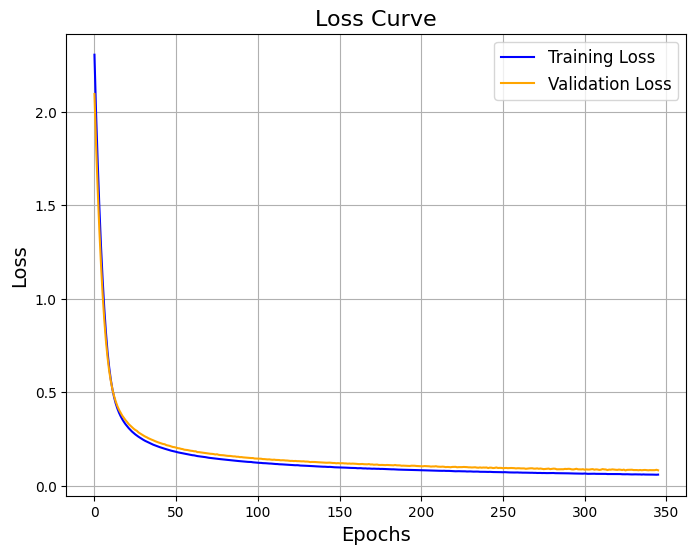

In [768]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,mode = 'min')
history = model.fit(X_train_nn, y_train_nn, epochs=500, batch_size=32, validation_data=(X_test_nn, y_test_nn),callbacks=[early_stopping])

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test_nn, y_test_nn)
print(f"Test Accuracy: {test_acc:.4f}")

train_loss = history.history['loss']  # train loss
val_loss = history.history['val_loss']  # val loss

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### Test our model on the valid set

In [769]:
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities for the test data
y_prob = model.predict(X_val_nn)  

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_prob, axis=1)  

# Ensure y_test is also in integer class indices (not one-hot encoded)
# If y_test is one-hot encoded, convert it:
if y_val_nn.ndim > 1:
    y_true = np.argmax(y_val_nn, axis=1)
else:
    y_true = y_test
val_acc = model.evaluate(X_val_nn, y_val_nn)

print(f"NN Accuracy: {val_acc[1]}")
# Generate the classification report
report = classification_report(y_true, y_pred)  
print(report)
print(y_train)

6/6 [==============================] - 0s 895us/step - loss: 0.0583 - accuracy: 1.0000
NN Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        23

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

1640       G
1372      Em
956        C
809     Bdim
726     Bdim
        ... 
1463       F
265        F
229       Em
898        C
1745       G
Name: chord, Length: 1231, dtype: object


### Create a confusion matrix to better visualize the predictions

Confusion Matrix:


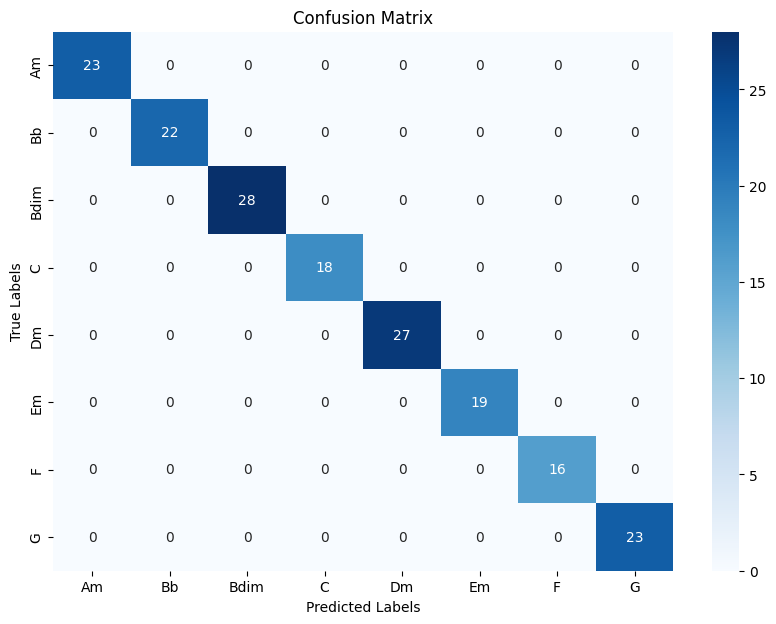

In [770]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CHORD_SET, yticklabels=CHORD_SET)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
